<a href="https://colab.research.google.com/github/wxmiked/cannabis-deforestation/blob/feature-add-download-naip/notebooks/custom_raster_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAIP Custom Raster Datasets

Mike Dvorak [mike@weathertactics.io](mailto:mike@weathertactics.io)

A custom `GeoDataset` class for the [Microsoft Planetary Computer NAIP archive](https://planetarycomputer.microsoft.com/dataset/naip). This notebook is derived from the Custom Raster Datasets tutorial on the TorchGeo site originally written by Ritwik Gupta.

## Setup

First, we install TorchGeo and a couple of other dependencies for downloading data from Microsoft's Planetary Computer.

In [128]:
%pip install torchgeo planetary_computer pystac

155560.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


## Imports

Next, we import TorchGeo and any other libraries we need.

In [129]:
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import planetary_computer
import pystac
import torch
from torch.utils.data import DataLoader

from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler
from torchgeo.transforms import AppendNDBI, AppendNDVI, AppendNDWI

%matplotlib inline
plt.rcParams['figure.figsize'] = (4, 4)

## Downloading

Let's download some data to play around with. In this example, we'll create a dataset for loading Sentinel-2 images. Yes, TorchGeo already has a built-in class for this, but we'll use it as an example of the steps you would need to take to add a dataset that isn't yet available in TorchGeo. We'll show how to download a few bands of Sentinel-2 imagery from the Planetary Computer. This may take a few minutes.

In [130]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [131]:
time_range = "2016-01-01/2016-12-31"
bbox = [-120.64352644032967, 38.172243149955314, -120.47900955503205, 38.32443090099175]

search = catalog.search(collections=["naip"], bbox=bbox, datetime=time_range)
items = search.item_collection()
items

In [132]:
import os
from urllib.parse import urlparse
import tempfile

root = os.path.join(tempfile.gettempdir(), 'naip')
os.makedirs(root, exist_ok=True)  # Ensure the directory exists

for item in items:
    signed_item = planetary_computer.sign(item)
    url = signed_item.assets["image"].href
    filename = urlparse(url).path.split('/')[-1]
    
    # Check if file already exists
    filepath = os.path.join(root, filename)
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        download_url(url, root, filename)
    else:
        print(f"Skipping {filename} - already exists")

Skipping m_3812053_sw_10_h_20160620.tif - already exists
Skipping m_3812053_nw_10_h_20160620.tif - already exists
Skipping m_3812052_sw_10_h_20160620.tif - already exists
Skipping m_3812052_se_10_h_20160620.tif - already exists
Skipping m_3812052_nw_10_h_20160620.tif - already exists
Skipping m_3812052_ne_10_h_20160620.tif - already exists
Skipping m_3812051_se_10_h_20160620.tif - already exists
Skipping m_3812051_ne_10_h_20160620.tif - already exists
Skipping m_3812045_sw_10_h_20160620.tif - already exists
Skipping m_3812045_nw_10_h_20160620.tif - already exists
Skipping m_3812044_sw_10_h_20160620.tif - already exists
Skipping m_3812044_se_10_h_20160620.tif - already exists
Skipping m_3812044_nw_10_h_20160620.tif - already exists
Skipping m_3812044_ne_10_h_20160620.tif - already exists
Skipping m_3812043_se_10_h_20160620.tif - already exists
Skipping m_3812043_ne_10_h_20160620.tif - already exists


This downloads the following files:

In [133]:
sorted(os.listdir(root))

['m_3812043_ne_10_h_20160620.tif',
 'm_3812043_se_10_h_20160620.tif',
 'm_3812044_ne_10_h_20160620.tif',
 'm_3812044_nw_10_h_20160620.tif',
 'm_3812044_se_10_h_20160620.tif',
 'm_3812044_sw_10_h_20160620.tif',
 'm_3812045_nw_10_h_20160620.tif',
 'm_3812045_sw_10_h_20160620.tif',
 'm_3812051_ne_10_h_20160620.tif',
 'm_3812051_se_10_h_20160620.tif',
 'm_3812052_ne_10_h_20160620.tif',
 'm_3812052_nw_10_h_20160620.tif',
 'm_3812052_se_10_h_20160620.tif',
 'm_3812052_sw_10_h_20160620.tif',
 'm_3812053_nw_10_h_20160620.tif',
 'm_3812053_sw_10_h_20160620.tif']

## Defining a custom NAIP dataset

Using the filenames above, we can create new NAIP class that is a sub-class of `RasterDataset`. We also add a plotting function.

In [134]:
class Naip(RasterDataset):
    filename_glob = 'm_*.tif'
    filename_regex = r'^m_[0-9]{7}_[nsew]{2}_10_h_(?P<date>\d{8})'
    date_format = '%Y%m%d'
    is_image = True
    separate_files = False
    all_bands = ('R', 'G', 'B', 'NIR')
    rgb_bands = ('R', 'G', 'B',)

    # Normalize image to [0, 1]
    def __getitem__(self, index):
        sample = super().__getitem__(index)
        image = sample['image']
        image = (image - image.min()) / (image.max() - image.min())
        sample['image'] = image
        return sample

    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder the image
        image = sample['image'][rgb_indices].permute(1, 2, 0)

        # Plot the image
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig

In [135]:
naip_dataset = Naip(root)
print(naip_dataset)

Naip Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=701850.0, maxx=724770.0, miny=4222056.0, maxy=4250688.0, mint=1466406000.0, maxt=1466492399.999999)
    size: 16


Let's plot an image to see what it looks like. We'll use `RandomGeoSampler` to load small patches from each image.

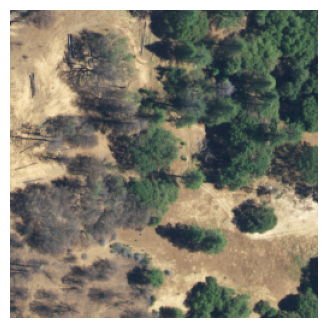

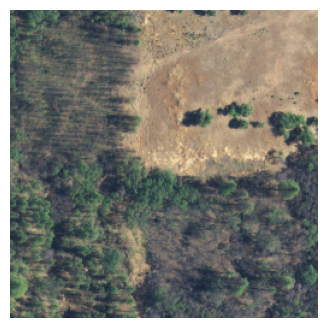

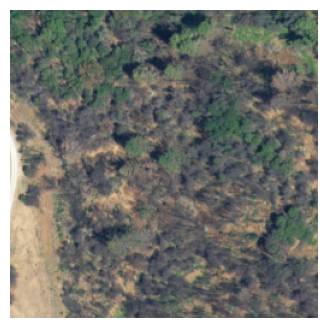

In [136]:
naip_dataset = Naip(root)
g = torch.Generator().manual_seed(1)
sampler = RandomGeoSampler(naip_dataset, size=256, length=3)
dataloader = DataLoader(naip_dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    naip_dataset.plot(sample)
    plt.axis('off')
    plt.show()
    plt.close()

# NDVI

Append Normalized Difference Vegetation Index (NDVI) and Normalized Difference Water Index (NDWI).

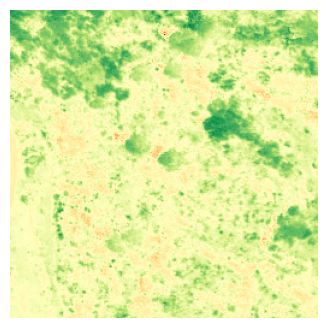

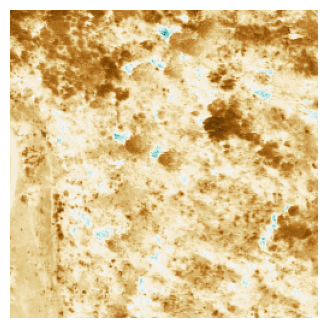

In [137]:
# NDVI is appended to channel dimension (dim=0)
indexNdvi = AppendNDVI(index_nir=naip_dataset.all_bands.index('NIR'), index_red=naip_dataset.all_bands.index('R'))
image = sample['image']
image = indexNdvi(image)[0]

# Normalize from [-1, 1] -> [0, 1] for visualization
image[-1] = (image[-1] + 1) / 2


plt.imshow(image[-1], cmap='RdYlGn')
plt.axis('off')
plt.show()
plt.close()

# NDWI is appended to channel dimension (dim=0)
indexNdwi = AppendNDWI(index_green=naip_dataset.all_bands.index('G'), index_nir=naip_dataset.all_bands.index('NIR'))
image = sample['image']
image = indexNdwi(image)[0]

# Normalize from [-1, 1] -> [0, 1] for visualization
image[-1] = (image[-1] + 1) / 2

plt.imshow(image[-1], cmap='BrBG')
plt.axis('off')
plt.show()
plt.close()

# CannabisParcelDataset

We use the parcels that are either cannabis permit parcels or not to train the model.

In [138]:
import torch
from torch.utils.data import Dataset
import geopandas as gpd
import rasterio

class CannabisParcelDataset(Dataset):
    def __init__(self, naip_dataset, permitted_shp, non_permitted_shp, transform=None):
        """
        Args:
            naip_dataset: An instance of your Naip(RasterDataset) class.
            permitted_shp: File path to the shapefile for permitted cannabis parcels.
            non_permitted_shp: File path to the shapefile for non-permitted cannabis parcels.
            transform: Optional transform to be applied on a sample.
        """
        self.naip = naip_dataset  # Instance of Naip(RasterDataset)
        self.transform = transform
        
        # Load parcel shapefiles using GeoPandas.
        permitted = gpd.read_file(permitted_shp)
        non_permitted = gpd.read_file(non_permitted_shp)
        
        # Prepare a unified list of (geometry bounds, label).
        # Label 1 = permitted to grow cannabis, 0 = non-permitted.
        self.samples = []
        for _, row in permitted.iterrows():
            self.samples.append((row.geometry.bounds, 1))
        for _, row in non_permitted.iterrows():
            self.samples.append((row.geometry.bounds, 0))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        bounds, label = self.samples[idx]
        # Create a window using the NAIP dataset's transform.
        window = rasterio.windows.from_bounds(*bounds, transform=self.naip.transform)
        # Extract the image patch using the Naip dataset's read method.
        patch = self.naip.read(window=window)
        
        # Apply any additional transforms (e.g., normalization, augmentation).
        if self.transform:
            patch = self.transform(patch)
        
        # Convert label to tensor.
        label = torch.tensor(label, dtype=torch.long)
        return patch, label


In [139]:
# Assuming Naip is defined elsewhere and imported
dataset = CannabisParcelDataset(
    naip_dataset=naip_dataset,
    permitted_shp="../cannabis-parcels/cannabis-registry-2018-commercial-apns.shp",
    non_permitted_shp="../cannabis-parcels/non-cannabis-parcels.shp"
)

# LightningModel and DataModule

In [144]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchgeo.models import Swin_V2_B_Weights

class CannabisDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 32,
        num_workers: int = 4,
        train_val_split: float = 0.8
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_split = train_val_split

    def setup(self, stage=None):
        # Create full dataset
        full_dataset = dataset
        
        # Split into train and val
        train_size = int(self.train_val_split * len(full_dataset))
        val_size = len(full_dataset) - train_size
        
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size]
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )
    


In [145]:
import torch
import pytorch_lightning as pl
from torch import nn
from torchmetrics import Accuracy
from torchgeo.models import Swin_V2_B_Weights, swin_v2_b

class CannabisModel(pl.LightningModule):
    def __init__(self, learning_rate: float = 1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        
        # Load pretrained Swin Transformer model with NAIP weights
        self.model = swin_v2_b(weights=Swin_V2_B_Weights.NAIP_RGB_MI_SATLAS)
        
        # Modify the final layer for binary classification
        num_features = self.model.head.in_features
        self.model.head = nn.Linear(num_features, 1)
        
        # Initialize metrics
        self.train_acc = Accuracy(task="binary")
        self.val_acc = Accuracy(task="binary")
        
        # Loss function
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)  # Ensure data is on the correct device
        y = y.to(self.device)
        y_hat = self(x)
        loss = self.criterion(y_hat.squeeze(), y.float())
        
        # Update metrics
        self.train_acc(y_hat.squeeze().sigmoid(), y)
        
        # Log metrics
        self.log("train_loss", loss)
        self.log("train_acc", self.train_acc)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat.squeeze(), y.float())
        
        # Update metrics
        self.val_acc(y_hat.squeeze().sigmoid(), y)
        
        # Log metrics
        self.log("val_loss", loss)
        self.log("val_acc", self.val_acc)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Training

In [146]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

def train():
    # Initialize data module
    data_module = CannabisDataModule(
        batch_size=32,
        num_workers=4
    )

    # Initialize model
    model = CannabisModel(learning_rate=1e-3)

    # Define callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints",
        filename="cannabis-{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        mode="min"
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min"
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback, early_stopping],
        accelerator="auto",
        devices=1
    )

    # Train the model
    trainer.fit(model, data_module)

if __name__ == "__main__":
    train() 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | SwinTransformer   | 86.9 M | train
1 | train_acc | BinaryAccuracy    | 0      | train
2 | val_acc   | BinaryAccuracy    | 0      | train
3 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
86.9 M    Trainable params
0         Non-trainable params
86.9 M    Total params
347.627   Total estimated model params size (MB)
435       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/wxmiked/vscode-workspace/cannabis/cannabis-deforestation/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined